In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import sys
import numpy as np
import random
from utils import *
import math
from net_files.model import CSRNet
from cropping_strategy.eval_as_a_whole import *
import torchvision.transforms as transforms
from Dataset_processing.TrainDatasetConstructor import TrainDatasetConstructor
from Dataset_processing.EvalDatasetConstructor import EvalDatasetConstructor
from net_files.metrics import *
from PIL import Image
import time
%matplotlib inline

In [2]:
# config
config = {
'SHANGHAITECH': 'A',
'min_RATE':10000000,
'min_MAE':10240000,
'min_MSE':10240000,
'eval_num':182,
'train_num':300,
'learning_rate': 1e-4,
'train_batch_size': 1,
'epoch': 100000,
'eval_per_step': 1200,
'mode':'whole'
}
img_dir = "/home/zzn/Documents/Datasets/part_" + config['SHANGHAITECH'] + "_final/train_data/images"
gt_dir = "/home/zzn/Documents/Datasets/part_" + config['SHANGHAITECH'] + "_final/train_data/gt_map"
img_dir_t = "/home/zzn/Documents/Datasets/part_" + config['SHANGHAITECH'] + "_final/test_data/images"
gt_dir_t = "/home/zzn/Documents/Datasets/part_" + config['SHANGHAITECH'] + "_final/test_data/gt_map"
model_save_path = "/home/zzn/Downloads/CSRNet_pytorch-master/checkpoints/model_a_whole_original.pkl"

In [3]:
# data_load
train_dataset = TrainDatasetConstructor(img_dir, gt_dir, config['train_num'], mode=config['mode'])
eval_dataset = EvalDatasetConstructor(img_dir_t, gt_dir_t, config['eval_num'], mode=config['mode'])
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=config['train_batch_size'])
eval_loader = torch.utils.data.DataLoader(dataset=eval_dataset, batch_size=1)

In [4]:
# obtain the gpu device
assert torch.cuda.is_available()
cuda_device = torch.device("cuda")

# model construct
net = CSRNet().cuda()
# net = torch.load("/home/zzn/Downloads/CSRNet_pytorch-master/checkpoints/model_a_whole_differ_loss_12:08_0329.pkl")
# set optimizer and estimator

optimizer = torch.optim.Adam(net.parameters(), config['learning_rate'])
criterion = Loss().cuda()
ae_batch = AEBatch().cuda()
se_batch = SEBatch().cuda()
modules = {'model':net, 'loss':criterion, 'ae':ae_batch, 'se':se_batch}

/home/zzn/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [ ]:
step = 0
for epoch_index in range(config['epoch']):
    dataset = train_dataset.shuffle()
    loss_list = []
    for train_img_index, train_img, train_gt, data_ptc in train_loader:
#         if step % config['eval_per_step'] == 0:
# #             start = time.time()
#             validate_MAE, validate_loss, validate_RMSE, time_cost = eval_model(config, eval_loader, modules, True)
# #             torch.cuda.synchronize()
# #             end = time.time()
#             print("time cost eval:", time_cost)
#             sys.stdout.write('In step {}, epoch {}, with loss {}, MAE = {}, MSE = {}\n'.format(step, epoch_index + 1, validate_loss, validate_MAE, validate_RMSE))
#             sys.stdout.flush()

#             # save model
#             if config['min_MAE'] > validate_MAE:
#                 config['min_MAE'] = validate_MAE
#                 torch.save(net, model_save_path)
#             torch.save(net, "/home/zzn/Downloads/CSRNet_pytorch-master/checkpoints/model_in_time.pkl")
            
#             # return train model
            
        start = time.time()
        net.train()
        optimizer.zero_grad()
        # B
        x = train_img
        y = train_gt
        prediction = net(x)
        torch.cuda.synchronize()
        end1 = time.time()
        loss = criterion(prediction, y)
        loss.backward()
        optimizer.step()
        step += 1
        torch.cuda.synchronize()
        end2 = time.time()
#         if step == 400 * 100 or step == 400 * 1000 or step == 400 * 500:
#             config['eval_per_step'] = eval_steps_adaptive(step)
        
        sys.stdout.write('In step {}, the loss = {}, forward_time = {}, backward_time = {}\r'.format(step, loss, (end1 - start), (end2 - end1)))
        sys.stdout.flush()

In [6]:
print(train_img.shape)
print(list(a.parameters()))

torch.Size([1, 3, 192, 256])


torch.Size([1, 1, 544, 832])


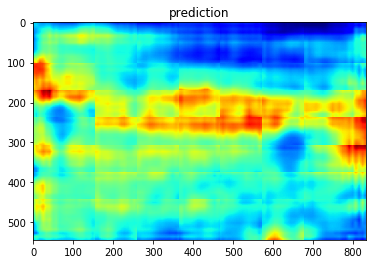

In [18]:
print(prediction_map.shape)
validate_pred_map = np.squeeze(prediction_map.permute(0, 2, 3, 1).data.cpu().numpy())
figure, (pred) = plt.subplots(1, 1, figsize=(20, 4))
pred.imshow(validate_pred_map, cmap=plt.cm.jet)
pred.set_title("prediction")
plt.show()

[[-250. -250. -250. ... -250. -250. -250.]
 [-249. -249. -249. ... -249. -249. -249.]
 [-248. -248. -248. ... -248. -248. -248.]
 ...
 [ 247.  247.  247. ...  247.  247.  247.]
 [ 248.  248.  248. ...  248.  248.  248.]
 [ 249.  249.  249. ...  249.  249.  249.]]


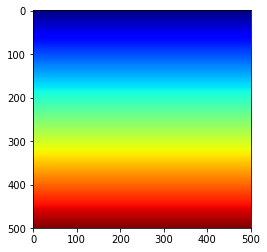

In [6]:
map_rand = np.random.randn(500, 500)
for i in range(500):
    for j in range(500):
        map_rand[i][j] = -250 + i
print(map_rand)
figure, orgin = plt.subplots(1, 1, figsize=(20, 4))
orgin.imshow(map_rand, cmap=plt.cm.jet)
plt.show()

In [4]:

params = list(list(net.children())[0].parameters())
k = 0
for i in params:
    l = 1
    print("该层的结构：" + str(list(i.size())))
    for j in i.size():
        l *= j
    
    print("该层参数和：" + str(l))
    
    k = k + l
print("总参数数量和：" + str(k))

该层的结构：[64, 3, 3, 3]
该层参数和：1728
该层的结构：[64]
该层参数和：64
该层的结构：[64, 64, 3, 3]
该层参数和：36864
该层的结构：[64]
该层参数和：64
该层的结构：[128, 64, 3, 3]
该层参数和：73728
该层的结构：[128]
该层参数和：128
该层的结构：[128, 128, 3, 3]
该层参数和：147456
该层的结构：[128]
该层参数和：128
该层的结构：[256, 128, 3, 3]
该层参数和：294912
该层的结构：[256]
该层参数和：256
该层的结构：[256, 256, 3, 3]
该层参数和：589824
该层的结构：[256]
该层参数和：256
该层的结构：[256, 256, 3, 3]
该层参数和：589824
该层的结构：[256]
该层参数和：256
该层的结构：[512, 256, 3, 3]
该层参数和：1179648
该层的结构：[512]
该层参数和：512
该层的结构：[512, 512, 3, 3]
该层参数和：2359296
该层的结构：[512]
该层参数和：512
该层的结构：[512, 512, 3, 3]
该层参数和：2359296
该层的结构：[512]
该层参数和：512
总参数数量和：7635264
